# 생존분석 진행 예시

간단한 형태의 생존분석을 진행해본 예시입니다. 한번에 바로 다변량 모델링을 시도하시기보다는 아래처럼 step-by-step으로 접근하시기를 권장드립니다.

더불어 몇가지 짚어야 할 이슈가 있는데, 이 또한 아래에 하이라이트해 두었습니다. 데이터 추출 시 고려해주시고, 논의 필요 사항은 서면 or 다음번 세션에서 논의하시지요.

In [15]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
warnings.filterwarnings('ignore')

# 빠른 처리를 위해 우선 10만줄 정도의 데이터만으로 분석을 진행했습니다
surv_data = pd.read_csv('team1/해지데이터2 (1).csv', delimiter='\t').sample(n=100000, random_state=123)

## 데이터 탐색

In [6]:
# 해지 이벤트 비중 확인
event_counts = surv_data['EVENT'].value_counts()
print(event_counts)

EVENT
0    98518
1     1482
Name: count, dtype: int64


제가 보는 데이터에서는 해지 고객의 비중이 매우 적게 나오는 듯 합니다. 새로 추출한 데이터에 대해서도 한번 점검해보시면 좋겠습니다.

In [7]:
# 해지한 고객들의 DURATION 평균 및 중앙값 계산
duration_stats = surv_data[surv_data['EVENT'] == 1]['DURATION'].agg(['mean', 'median'])
print(duration_stats)

mean      1242.825911
median    1221.000000
Name: DURATION, dtype: float64


이 또한 지난 세션에서는 평균 800일 정도로 확인했는데, 현재 데이터에서는 1200여일 정도로 나옵니다.

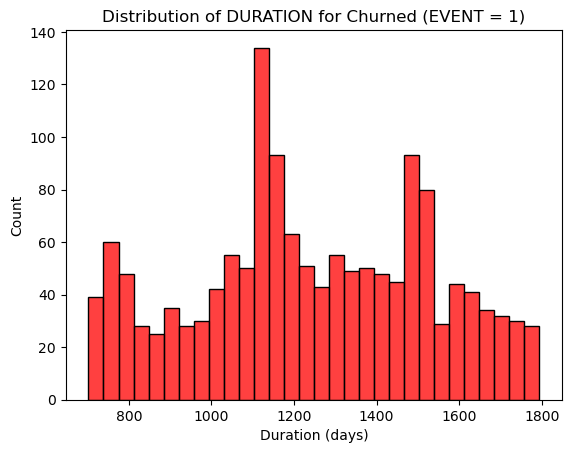

In [17]:
# 해지 고객의 유지 기간 히스토그램
sns.histplot(data=surv_data[surv_data['EVENT'] == 1], x='DURATION', bins=30, kde=False, color='red')
plt.title('Distribution of DURATION for Churned (EVENT = 1)')
plt.xlabel('Duration (days)')
plt.ylabel('Count')
plt.show()

위를 보면 하나의 이슈를 생각할 수 있는데요. 600여일 이전에 해지한 고객은 없는 것으로 나옵니다. 따라서 우리의 모델링에서도 600일 이전의 생존확률은 100%로 나오는 것이죠. 이를 해결할 수 있는 옵션으로는,

1. 'x개월 이상 유지한 고객만'이라는 필터링 조건 없이 추출하는 방법
2. 생존분석 모델에서 left censoring을 설정하는 방법

두 가지가 있습니다. 1번이 조금 더 직관적일 것으로 생각됩니다.

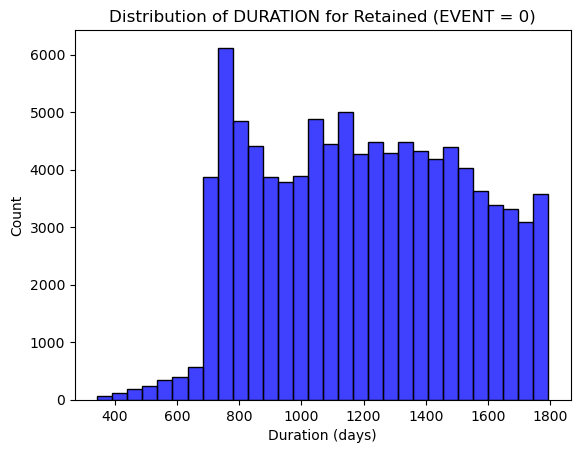

In [19]:
# 지속 고객의 유지 기간 히스토그램
sns.histplot(data=surv_data[surv_data['EVENT'] == 0], x='DURATION', bins=30, kde=False, color='blue')
plt.title('Distribution of DURATION for Retained (EVENT = 0)')
plt.xlabel('Duration (days)')
plt.ylabel('Count')
plt.show()

## 데이터 전처리

한 가지 문제가, 일 단위로 분석하면 변동성이 크고 일반성이 떨어질 수 있다는 점이었습니다. 때문에 조금 더 넓은 단위로 바꿔서 진행하는 것을 추천드립니다. 여기서는 주 단위로 변경해보았습니다.

In [20]:
# 유지 기간을 주 단위로 변환
surv_data['DURATION_WEEK'] = np.ceil(surv_data['DURATION'] / 7)

## 모델링

### X 변수 없이 생존분석

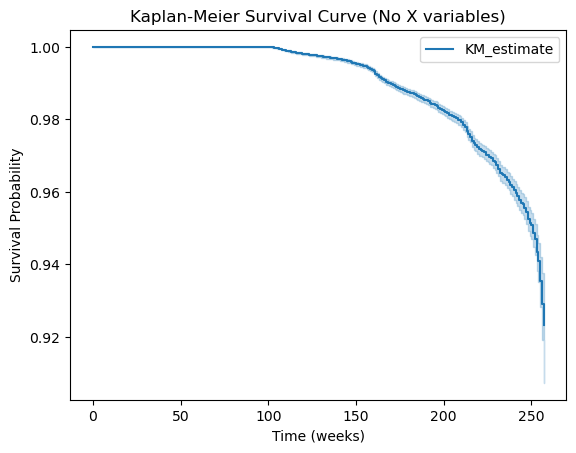

In [21]:
# Kaplan-Meier Fitter 객체 생성
kmf = KaplanMeierFitter()

# 모델 적합
kmf.fit(durations=surv_data['DURATION_WEEK'], event_observed=surv_data['EVENT'])

# 생존곡선 그리기
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (No X variables)')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')
plt.show()

현재 분석 상으로는 250주가 지날 때까지 생존 확률이 90% 대에 머무는 것을 볼 수 있습니다. 이건 실제와는 다소 거리가 있어보이는데요, 아마도 해지고객이 undersampling된 것으로 생각됩니다.

데이터 추출 로직에 숨겨진 변수가 있는 듯 한데요. 일단 추출 과정을 저와 정제해보시고, 정 안되면 (바람직한 방법은 아니지만) 지난번 보여주신 월 이탈율 1%를 토대로 역산하는 방법도 있습니다. 즉, 추출해주신 데이터를 이탈율 1%가 나오도록 존속 고객을 undersampling하는 것이죠.

### X 변수 1개 포함한 생존분석

위 분석이 정상적으로 되면 여기서부터는 X값들을 하나씩 넣으면서 보충해보시면 좋겠습니다. 아래는 번들 갯수를 0, 1, 2, 3+으로 나누어 분석한 내용입니다.

In [22]:
# COUNT_BUNDLE2 변수 생성
surv_data['COUNT_BUNDLE2'] = surv_data['COUNT_BUNDLE'].apply(lambda x: str(x) if x in [0, 1, 2] else '3+')

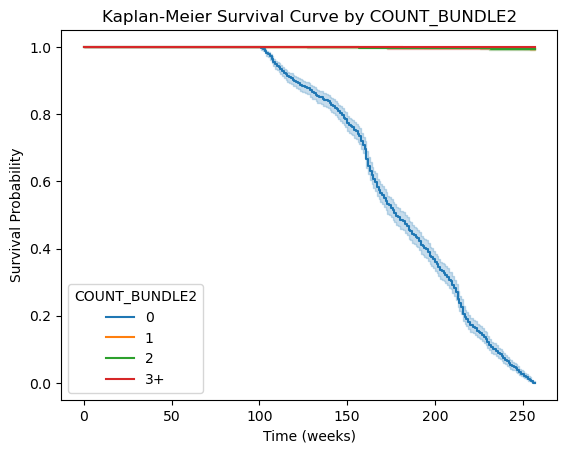

In [23]:
for name, grouped_df in surv_data.groupby('COUNT_BUNDLE2'):
    kmf.fit(durations=grouped_df['DURATION_WEEK'], event_observed=grouped_df['EVENT'], label=name)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by COUNT_BUNDLE2')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')
plt.legend(title='COUNT_BUNDLE2')
plt.show()

### X 변수 2개 포함한 생존분석

마찬가지로 PURE_RATE(이용 요금일까요?)를 추가로 넣어서 분석한 내용입니다. 여기서는 설명을 위해 요금 기준 1, 2, 3, 4분위로 나누어 범주형으로 분석을 진행했습니다. 모델링 시에는 꼭 범주형으로 바꾸어야 하는 것은 아닙니다.

In [24]:
# 사분위수 계산
quantiles = surv_data['PURE_RATE'].quantile([0, 0.25, 0.5, 0.75, 1.0])

# PURE_RATE2 변수 생성
surv_data['PURE_RATE2'] = pd.cut(surv_data['PURE_RATE'],
                                 bins=quantiles,
                                 labels=['Q1', 'Q2', 'Q3', 'Q4'],
                                 include_lowest=True)

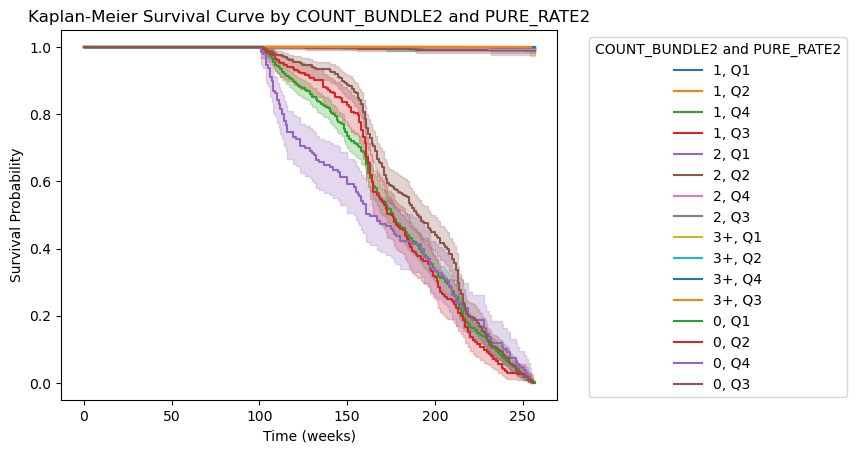

In [26]:
from itertools import product

# COUNT_BUNDLE2와 PURE_RATE2의 고유값 조합 생성
combinations = list(product(surv_data['COUNT_BUNDLE2'].unique(), surv_data['PURE_RATE2'].unique()))

for cb, pr in combinations:
    mask = (surv_data['COUNT_BUNDLE2'] == cb) & (surv_data['PURE_RATE2'] == pr)
    if mask.sum() > 0:
        kmf.fit(durations=surv_data[mask]['DURATION_WEEK'], event_observed=surv_data[mask]['EVENT'], label=f'{cb}, {pr}')
        kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve by COUNT_BUNDLE2 and PURE_RATE2')
plt.xlabel('Time (weeks)')
plt.ylabel('Survival Probability')
plt.legend(title='COUNT_BUNDLE2 and PURE_RATE2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Action item 및 이슈 사항 정리

1. 위와 같이 간단한 전체 모델링부터 시작해서 step-by-step으로 진행해보시는 것을 추천드립니다.
2. 일 단위로 모델링을 했을 때 일반화 가능성이 많이 떨어지는 것 같습니다. 주 또는 월 단위의 모델링이 좋을 것 같습니다.
3. 해지:비해지의 비율에 있어 아직 bias가 있어 보입니다. 샘플링 로직에 이슈가 있는 듯 한데요. 우선 데이터를 추출 과정을 정제해 보시되, 해결이 안되시면 우선은 이렇게 하시죠.
   
   a. 최대한 많은 고객을 현재 추출 기준으로 추출 (20만명 이상도 좋습니다)

   b. 월 이탈율 1%가 되도록 존속 고객을 undersamping (재 샘플링)

   c. 1차는 위 데이터로 분석 진행하되, 추출 기준 자체를 차차 다듬어 인위적인 재 샘플링 없이 되도록 함

4. 18개월 이전 해지한 고객이 제외된다는 이슈가 있는데요. 이 필터링 조건은 제외하시거나 아니면 생존 분석에서 left censoring을 고려하시면 좋겠습니다.